In [1]:
from hyp_solver3 import HypProblem, Mesh, Solver, solve_oc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from time import time

In [8]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]
# C = [2.3,0.9]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))

G11 = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G12 = lambda t: - G11(t)
G21_ = lambda t: (np.sin(t)) / (np.cos(t) - 4* np.sin(t))
G21 = lambda t: G21_(t) - 1
G22 = lambda t: - G21(t)

F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0

phi_dx = lambda s, x, y : -2*(x - x_an(s, T[1])) 
phi_dy = lambda s, x, y : -2*(y - y_an(s, T[1]))

hyp_problem = HypProblem(T=T, S=S, C=C, B=[[B11, B12], [B21, B22]], 
                         F=[F1, F2], G=[[G11, G12], [G21, G22]], 
                         X0=x0, Y0=y0, phi_dx=phi_dx, phi_dy=phi_dy)

mesh = Mesh(hyp_problem, 100)
solver = Solver()
solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)


In [9]:
def plot_sys(mesh):
    plt.figure(figsize=(12,6))
    
    nodes = mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    
    plt.subplot(3, 2, 1)
    plt.plot(s, x, "ro")
    plt.plot(s, [x_an(si, T[1]) for si in s], "b-")
    plt.ylabel("x")
    plt.grid()
    plt.subplot(3, 2, 3)
    plt.plot(s, y, "ro")
    plt.plot(s, [y_an(si, T[1]) for si in s], "b-")
    plt.ylabel("y")
    plt.xlabel("s")
    plt.grid()

    deltas_x = [abs(xi-x_an(si,T[1])) for si, xi in zip(s, x)]
    deltas_y = [abs(yi-y_an(si,T[1])) for si, yi in zip(s, y)]
        
    print(f"t= t1:\n\tdx:{np.max(deltas_x)}\n\tdy:{np.max(deltas_y)}")

    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    plt.subplot(3, 2, 2)
    plt.plot(t, x, "ro")
    plt.plot(t, [x_an(S[0], ti) for ti in t], "b-")
    plt.grid()
    plt.legend(["x", "x_an"])
    plt.subplot(3, 2, 4)
    plt.plot(t, y, "ro")
    plt.plot(t, [y_an(S[0], ti) for ti in t], "b-")
    plt.legend(["y", "y_an"])
    plt.grid()

    deltas_x = [abs(xi-x_an(S[0],ti)) for ti, xi in zip(t, x)]
    deltas_y = [abs(yi-y_an(S[0],ti)) for ti, yi in zip(t, y)]
        
    print(f"s=s0:\n\tdx:{np.max(deltas_x)}\n\tdy:{np.max(deltas_y)}")

    
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    v_true = [G22_true(ti) for ti in t]
    v = [hyp_problem.G22(ti) for ti in t]
    plt.subplot(3, 2, 6)
    plt.plot(t, v, "ro")
    plt.plot(t, v_true, "b-")
    plt.legend(["v", "v_an"])
    plt.ylabel("v")
    plt.xlabel("t")
    plt.grid()

In [10]:
# Первое приближение ===============================================
# uk_0 = np.random.random(len(t_h))
G22_0 = lambda t: G22_true(t)+1
# G22_0 = lambda t: G22_true(t)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)



t= t1:
	dx:0.00013846054179433853
	dy:0.06704426898888038
s=s0:
	dx:3.216527706562111e-05
	dy:0.06436294146277777


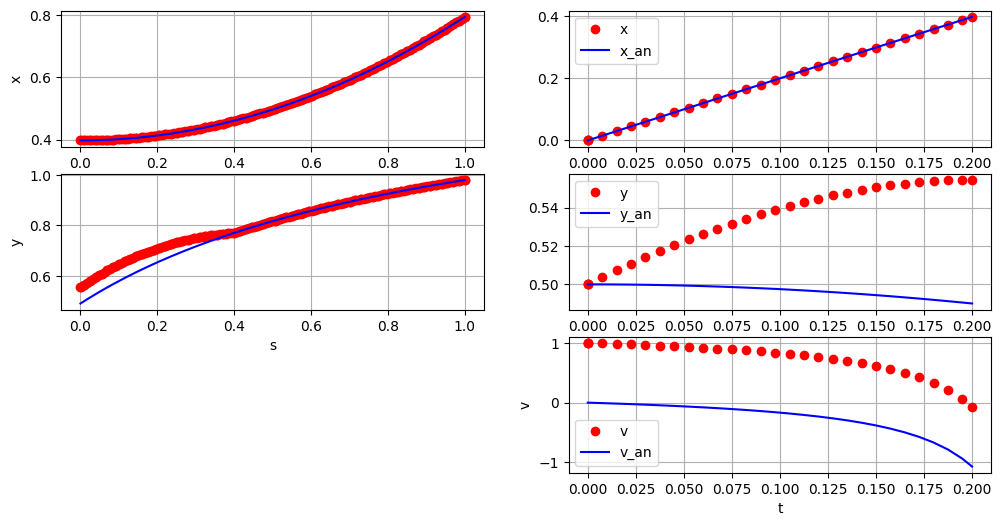

In [11]:
plot_sys(mesh)

In [12]:
U0 = lambda t: G22(t)
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=[-2.5, 1], eps=0.001, debug=True, method= "mpm")
print(f"сек:{time()-start_time:.2f}")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.9912183730190177e-06
        x: [ 3.276e-01  1.000e+00 ...  3.437e-02 -7.530e-02]
      nit: 4
      jac: [ 1.537e-06  0.000e+00 ...  1.096e-07  1.644e-08]
 hess_inv: [[ 3.657e+02  0.000e+00 ...  1.352e+01  1.991e+00]
            [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 1.352e+01  0.000e+00 ...  1.501e+00  7.383e-02]
            [ 1.991e+00  0.000e+00 ...  7.383e-02  1.011e+00]]
     nfev: 310
     njev: 10
сек:42.01


t= t1:
	dx:5.954998152146729e-06
	dy:0.00788043693290802
s=s0:
	dx:4.651989349013785e-06
	dy:0.00788043693290802


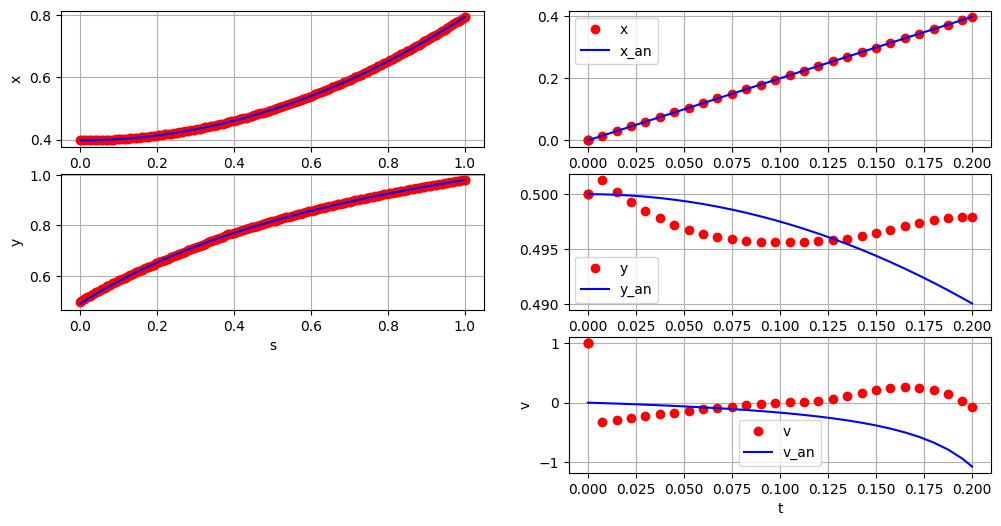

In [13]:
plot_sys(mesh)